#  Simulated Annealing

##### Keywords: simulated annealing, metropolis-hastings, MCMC, temperature, travelling salesman problem

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## for TSP material
import random
import time
import itertools
import urllib
import csv
import functools
from statistics import mean, stdev
import math

## Optimization

Welcome to Lab 5.  Today we're going to discuss simulated annealing (SA) with a particular focus on the Traveling Salesman Problem frequently referred to as TSP. 

**Simulated Annealing** is a very popular optimization algorithm because it's very robust to different types of functions (e.g. no continuity, differentiability  or dimensionality requirements) and can find global minima/maxima.

## The Simulated Annealing Algorithm

So now we have a better sense of how to find peaks (valleys) and then find optima.  First use Metropolis-Hastings sampling at high temperatures to travel around the distribution and find all the peaks (valleys).  Slowly cool down the temperature which will focus you in a particular optima region and allow you to find the optima.

1. Initialize $x_i,T, L(T)$ where $L$ is the number of iterations at a particular temperature. 
2. Perform $L$ transitions thus(we will call this an epoch):
    1. Generate a new proposed position $x$
    2. If $x$ is accepted (according to probability $P = e^{(-\Delta E/T)}$, set $x_{i+1} = x_j$, else set $x_{i+1} = x_{i}$  
3. Update T and L 
4. Until some fixed number of epochs, or until some stop criterion is fulfilled, goto 2.


![SA flowchart](http://apmonitor.com/me575/uploads/Main/sim_annealing_flow.png)

(via [BYU ME 575 SA Tutorial](http://apmonitor.com/me575/index.php/Main/SimulatedAnnealing))

![xkcd travelling salesman](http://imgs.xkcd.com/comics/travelling_salesman_problem.png)

(via [xkcd](http://xkcd.com/399/))



## Traveling Salesman Problem (TSP)

This section and the ones that follow is heavily indebted to (if not lifted almost entirely from) Peter Norvig's iPython Notebook on the TSP.  I highly recommend you visit that notebook and all his other notebooks at http://norvig.com/ipython/

Some optimization problems are ***combinatorial***, in the sense that there are $p$ items that can be ordered or combined in many different ways, some ways being better than others according to a set of specified criteria.

Consider the [*Traveling Salesperson Problem*](http://en.wikipedia.org/wiki/Traveling_salesman_problem): 

> *Given a set of cities and the distances between each pair of cities, what is the shortest possible tour that visits each city exactly once, and returns to the starting city?*

Assuming travel is the same distance irrespective of travel direction, there are:

$$\frac{(p-1)!}{2}$$

possible routes. So, 5 cities have 120 possible routes, 10 cities have 181,440 routes, 50 cities have $3 \times 10^{64}$ routes!

<a href="http://www.math.uwaterloo.ca/tsp/history/pictorial/dfj.html"><img src="http://www.math.uwaterloo.ca/tsp/history/img/dantzig.gif"></a>
<center>An example tour.</center>
                                     
### Definitions

We'll use a `set` to get a "set" of cities.

- **Distance between each pair of cities**: If `A` and `B` are cities, this could be a function, `distance(A, B),` or a table lookup, `distance[A][B]`.  The resulting distance will be a real number.

- **Tour**: A tour is a specified order in which to visit the cities; Python's `list` or `tuple` datatypes would work. For example, given the set of cities `{A, B, C, D}`, a tour might be the list `[B, D, A, C]`, which means to travel from `B` to `D` to `A` to `C` and finally back to `B`.
- **Shortest possible tour**: The shortest tour is the one whose tour length is the minimum of all tours.
- **Tour length**: The sum of the distances between adjacent cities in the tour (including the last city back to the first city).   Probably  a function, `tour_length(tour)`.

Let's start with a bruteforce algorithm that is guaranteed to solve the problem, although it is inefficient for large sets of cities:

> **All Tours Algorithm**: *Generate all possible tours of the cities, and choose the shortest tour (the one with minimum tour length).*


Let's begin the implementation:

In [2]:
def alltours_tsp(cities):
    "Generate all possible tours of the cities and choose the shortest tour."
    return shortest_tour(alltours(cities))

def shortest_tour(tours): 
    "Choose the tour with the minimum tour length."
    return min(tours, key=tour_length)


Now for the `alltours` function.  If a tour is a sequence of cities, then all the tours are *permutations* of the set of all cities. A function to generate all permutations of a set is already provided in Python's standard `itertools` library module; we can use it as our implementation of `alltours`.  We take some steps to make tours non-redundant as well.

In [3]:
def alltours(cities):
    "Return a list of tours, each a permutation of cities, but each one starting with the same city."
    start = first(cities)
    return [[start] + Tour(rest)
            for rest in itertools.permutations(cities - {start})]

def first(collection):
    "Start iterating over collection, and return the first element."
    return next(iter(collection))

Tour = list  # Tours are implemented as lists of cities

The length of a tour is the sum of the lengths of each edge in the tour; in other words, the sum of the distances between consecutive cities in the tour, including the distance form the last city back to the first:

In [4]:
def tour_length(tour):
    "The total of distances between each pair of consecutive cities in the tour."
    return sum(distance(tour[i], tour[i-1]) 
               for i in range(len(tour)))

**Trick**: when `i` is 0, then `distance(tour[0], tour[-1])` gives us the wrap-around distance between the first and last cities, because `tour[-1]` is the last element of `tour`. 

In the fully general version of the TSP, the "distance" between two cities could be anything: it could factor in the amount of time it takes to travel between cities, the twistiness of the road, or anything else (see the homework :-)). So the distances could be represented by a matrix `distance[A][B]`, where any entry in the matrix could be any (non-negative) numeric value.
    
Here we will just consider the straight-line distance between points in a two-dimensional plane. This is symmetric. 
        
OK, so a city can be represented as just a two-dimensional point. But how will we represent points?  

In [5]:
# Cities are represented as Points, which are a subclass of complex numbers
from collections import namedtuple

City = namedtuple('City', ['x', 'y'], verbose=True)

from builtins import property as _property, tuple as _tuple
from operator import itemgetter as _itemgetter
from collections import OrderedDict

class City(tuple):
    'City(x, y)'

    __slots__ = ()

    _fields = ('x', 'y')

    def __new__(_cls, x, y):
        'Create new instance of City(x, y)'
        return _tuple.__new__(_cls, (x, y))

    @classmethod
    def _make(cls, iterable, new=tuple.__new__, len=len):
        'Make a new City object from a sequence or iterable'
        result = new(cls, iterable)
        if len(result) != 2:
            raise TypeError('Expected 2 arguments, got %d' % len(result))
        return result

    def _replace(_self, **kwds):
        'Return a new City object replacing specified fields with new values'
        result = _self._make(map(kwds.pop, ('x', 'y'), _self))
        if kwds:
            raise ValueError('Got unexpected field names: %r' % list(kwds))
        return result

    def __repr__(self):
        'Return a nicely formatted represen

In [6]:
import math

def distance(A, B): 
    "The distance between two points."
    return math.sqrt((A.x - B.x)*(A.x - B.x) + (A.y - B.y)*(A.y - B.y))

def Cities(n, width=900, height=600, seed=42):
    "Make a set of n cities, each with random coordinates within a (width x height) rectangle."
    random.seed(seed * n)
    return frozenset(City(random.randrange(width), random.randrange(height))
                     for c in range(n))

def plot_tour(tour):
    "Plot the cities as circles and the tour as lines between them. Start city is red square."
    start = tour[0]
    plot_lines(list(tour) + [start])
    plot_lines([start], 'rs') # Mark the start city with a red square
    
def plot_lines(points, style='bo-'):
    "Plot lines to connect a series of points."
    plt.plot([p.x for p in points], [p.y for p in points], style)
    plt.axis('scaled'); plt.axis('off')
    
def plot_tsp(algorithm, cities):
    "Apply a TSP algorithm to cities, plot the resulting tour, and print information."
    # Find the solution and time how long it takes
    t0 = time.clock()
    tour = algorithm(cities)
    t1 = time.clock()
    assert valid_tour(tour, cities)
    plot_tour(tour); plt.show()
    print("{} city tour with length {:.1f} in {:.3f} secs for {}"
          .format(len(tour), tour_length(tour), t1 - t0, algorithm.__name__))
    
def valid_tour(tour, cities):
    "Is tour a valid tour for these cities?"
    return set(tour) == set(cities) and len(tour) == len(cities)

In [7]:
mycities = Cities(10, seed=332)

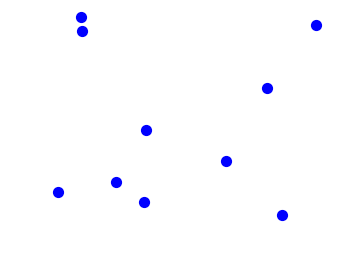

In [8]:
plot_lines(mycities, 'bo')

## Heuristics

Unfortunately, there is no known combinatorial optimization algorithm for obtaining an optimal solution to the TSP in polynomial time. Instead, we must turn to ***heuristics***, which have no guarantee of a global maximum, but in practice tend to yield *good* results in a reasonable time. Thus, we are trading off global optimality for a little speed.

Heuristics have two notable characteristics:

* **iteration**: candidate solutions are incrementally improved
* **localization**: search for improved solutions are restricted to a local neighborhood of the current solution

This ***local search*** approach encompasses several specific techniques, some of which we will explore here. For a given candidate solution vector $\mathbf{\theta}^{(t)}$ at iteration $t$, we might change components $\theta_i$ to propose an updated solution $\mathbf{\theta}^{(t+1)}$. Limiting the number of changes keeps $\mathbf{\theta}^{(t+1)}$ in the *neighborhood* of $\mathbf{\theta}^{(t)}$. We refer to $k$ changes to the candidate solution as a **k-change** and the set of possible new candidates as the *k-neighborhood*.

A sensible approach for updating a candidate solution is to choose the best candidate from the neighborhood; this is called ***steepest ascent***. The selection of any improved candidate is called an *ascent*. However, choosing the steepest ascent from a neighborhood may not be globally optimal if, for example, it takes us toward a local maximum at the cost of missing a global maximum. An algorithm that uses a steepest ascent strategy in the context of local search is called a *greedy* algorithm.

We can construct pretty readily a greedy algorithm for TSP.

Here is a description of the nearest neighbor algorithm:

> **Nearest Neighbor Algorithm:** *Start at any city; at each step extend the tour by moving from the previous city to its nearest neighbor that has not yet been visited.*

So now, instead of considering all *n*! tours, we are generating a single tour. It takes O(*n*<sup>2</sup> ) time to find the tour, because it has *n*-1 steps, and at each step we consider each of the remaining cities.

That gives us:

In [9]:
def nn_tsp(cities):
    """Start the tour at the first city; at each step extend the tour 
    by moving from the previous city to the nearest neighboring city, C,
    that has not yet been visited."""
    start = first(cities)
    tour = [start]
    unvisited = set(cities - {start})
    while unvisited:
        C = nearest_neighbor(tour[-1], unvisited)
        tour.append(C)
        unvisited.remove(C)
    return tour

def nearest_neighbor(A, cities):
    "Find the city in cities that is nearest to city A."
    return min(cities, key=lambda c: distance(c, A))

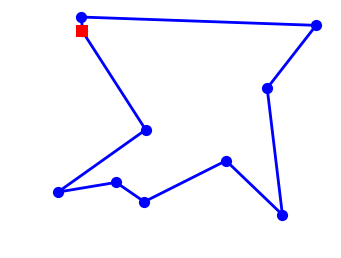

10 city tour with length 2043.1 in 5.076 secs for alltours_tsp


In [10]:
plot_tsp(alltours_tsp, mycities)

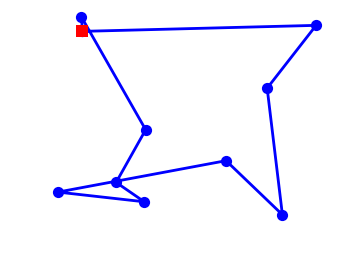

10 city tour with length 2198.8 in 0.000 secs for nn_tsp


In [11]:
plot_tsp(nn_tsp, mycities)

In order to attain a global maximum (or globally-competitive solution), it makes sense for a heuristic approach to  occasionaly choose an candidate solution that is not the best-in-neighborhood. In other words, to move from one peak to another (higher) peak, one must pass through valleys.  Hmmmm.... Where can we find an approach that does this?  Oh yeah!! Our good old buddy **simulated annealing**.


In [12]:
# def reverse_segment(input_tour, i, j):
#     "Reverse segment tour[i:j] of a tour" 
#     input_tour[i:j] = reversed(input_tour[i:j])
    

    
    
    
def change_tour(input_tour):
    "Change a tour for tsp iteration"
    
    #possible_indices = range(1, len(input_tour)) why not?
    possible_indices = range(len(input_tour))
    # take two random indices to swap
    c1 = np.random.choice(possible_indices)
    c2 = np.random.choice(possible_indices)
    
    new_tour = change_path(input_tour, c1, c2)
    
    return new_tour

    
    
def swap_cities(input_tour, i, j):
    "Swap two cities at index i and j in a tour"
    
    # save city1
    city1 = input_tour[i]
    
    # save city2
    city2 = input_tour[j]
    
    new_tour = input_tour.copy()
    
    # swap
    new_tour[j] = city1
    new_tour[i] = city2
        
    return new_tour
    
change_path = swap_cities  
    

In [13]:
# We've constructed our own simulated annealing function for tsp but we don't
# really need to make any changes.  So we'll just comment the regular sa :-)
def sa_tsp(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc):
    """
    Run simulated annealing on a tsp.
    """
    # Accumulate results in the same form as initals
    accumulator=[]
    
    # Our initial state is in initials['solution']
    best_solution = old_solution = initials['solution']
    
    # Our initial temperature is in initials['T']
    T=initials['T']
    
    # Our initial length (i.e. number of iterations per epoch)
    # is in initals['length']
    length=initials['length']
    
    # initialize the energy of our current state by running the 
    # energy function on our initial solution
    best_energy = old_energy = energyfunc(old_solution)
    
    # keep track of accepted proposals and total iterations
    accepted=0
    total=0
    
    for index in range(epochs):
        #print("Epoch", index)
        
        # if we're past the first index, we need
        # to update our cooling schedule and iteration
        # schedule
        if index > 0:
            T = tempfunc(T)
            length=iterfunc(length)
            
        if index % 100 == 0:
            print("Temperature", T, "Length", length)
        
        # run through the iterations for each epoch
        for it in range(length):
            
            # keep track of total proposals
            total+=1
            
            # get a new proposal and calculate its energy
            new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            
            # Use a min here as you could get a "probability" > 1
            alpha = min(1, np.exp((old_energy - new_energy)/T))
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
                
                # Accept proposed solution
                accepted+=1.0
                accumulator.append((T, new_solution, new_energy))
                
                # we have a new candidate for optimum (minimum)
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                    
                old_energy = new_energy
                old_solution = new_solution
            else:
                # Keep the old stuff
                accumulator.append((T, old_solution, old_energy))
    
    best_meta=dict(index=best_index, temp=best_temp)
    print("frac accepted", accepted/total, "total iterations", total, 'bmeta', best_meta)
    return best_meta, best_solution, best_energy, accumulator

In [14]:
initial_tour = list(mycities)
length_func1 = lambda temperature: np.max((np.floor(np.sqrt(temperature)).astype(int),1))
length_func2 = lambda length: max(int(math.ceil(1.2*length)), 10)
length_func = length_func1
temp_func = lambda t: 0.9*t

init_length = length_func(10000)

inits=dict(solution=initial_tour, length=init_length, T=50.0)

print(inits)
bmeta, bs, be, out = sa_tsp(tour_length, inits, 10000, temp_func, length_func, change_tour);


{'solution': [City(x=283, y=471), City(x=683, y=348), City(x=356, y=144), City(x=594, y=191), City(x=789, y=484), City(x=417, y=102), City(x=230, y=123), City(x=716, y=74), City(x=281, y=502), City(x=420, y=258)], 'length': 100, 'T': 50.0}
Temperature 50.0 Length 100
Temperature 0.0013280699443793769 Length 1
Temperature 3.527539554327681e-08 Length 1
Temperature 9.369638519424033e-13 Length 1
Temperature 2.4887070614692694e-17 Length 1
Temperature 6.610354097404112e-22 Length 1
Temperature 1.755802519693493e-26 Length 1
Temperature 4.663657109341013e-31 Length 1
Temperature 1.2387325675614017e-35 Length 1
Temperature 3.2902469842043867e-40 Length 1
Temperature 8.739356258613459e-45 Length 1
Temperature 2.3212952760576655e-49 Length 1
Temperature 6.165684976324033e-54 Length 1
Temperature 1.6376921807134844e-58 Length 1
Temperature 4.349939526701393e-63 Length 1
Temperature 1.1554047890559942e-67 Length 1
Temperature 3.068916747874519e-72 Length 1
Temperature 8.151472189309303e-77 Leng

In [15]:
bs

[City(x=281, y=502),
 City(x=283, y=471),
 City(x=420, y=258),
 City(x=230, y=123),
 City(x=356, y=144),
 City(x=417, y=102),
 City(x=594, y=191),
 City(x=716, y=74),
 City(x=683, y=348),
 City(x=789, y=484)]

2043.075492884944


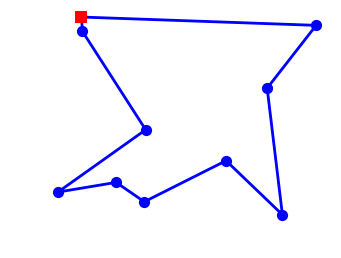

10 city tour with length 2043.1 in 0.000 secs for <lambda>


In [16]:
print(be)
plot_tsp(lambda x: bs, mycities)

Text(0,0.5,'f')

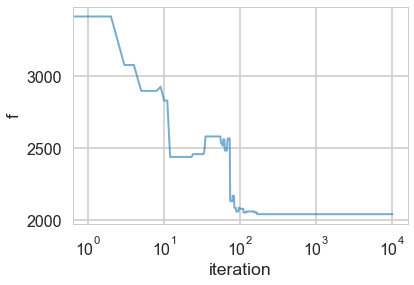

In [17]:
plt.plot(range(len(out)),[e[2] for e in out], alpha=0.6, lw=2);
plt.xscale('log')
plt.xlabel('iteration')
plt.ylabel('f')

## Practical Choices

*  Start with temperature $T_0$ large enough to accept all transitions. Its working against $\Delta E$, so should be at-least a bit higher than it.
* The proposal step size should lead to states with similar energy. This would exclude many bad steps
*  Lowering temperature schedule (thermostat). Common choices are
    1. Linear: Temperature decreases as  $T_{k+1} = \alpha T_k$. Typical values are $0.8 < \alpha < 0.99$. $k$ indexes epochs.
    2. Exponential: Temperature decreases as $0.95^{{\rm k}}$
    3. Logarithmic: Temperature decreases as $1/\log({\rm k})$
* Reannealing interval, or epoch length is the number of points to accept before reannealing (change the temperature). Typical starting value is 100, and you want to increase it as  $L_{k+1} = \beta L_k$ where $\beta > 1$.
* Larger decreases in temperature require correspondingly longer epoch lengths to re-equilibriate
* Running long epochs at larger temperatures is not very useful. In most problems local minima can be jumped over even at low temperatures. Thus it may be useful to decrease temperature rapidly at first.
* Stopping criterion
    1. Max iterations bounds the number of iterations the algorithm takes
    2. Function tolerance. The algorithm stops if the average change in the objective function after  $m$ iterations is below user specified tolerance
    3. Objective limit. The algorithm stops if the objective function goes below some value 
    
- It can be shown (although this is too slow a bound) that convergence to a set of global maxima is assured for $T_i = 1/(Clog(i + T_0))$ where $C$ and $T_0$ are problem dependent. The usual interpretation is that $C$ is the height of the tallest local minimum.
- Sometimes reheating is useful to explore new areas.

## Sudoku

For those who haven't seen these before, a sudoku puzzle typically consists of a square grid of 3x3 blocks each containing 3x3 cells. This has of course be scaled up to n>3 for really sadistic gamers, but we're going to stick with the well-known 3x3 situtation. The puzzle begins with  a variable number of  integers in specified (fixed) positions on the game board. The objective is to fill in the remaining cells so that each row, column and block contains only distinct and unique integers from 1 to 9. Easy! (...or not). Depending on the start position, these can sometimes be solved systematically by selecting individual empty cells that can only have one possible outcome based on the misisng integers from the associated row, column and block.

Here is an example where a systematic approach will not work:

In [18]:
def plot_sudoku(n):
    # Simple plotting statement that ingests a 9x9 array (n), and plots a sudoku-style grid around it.
    plt.figure()
    for y in range(10):
        plt.plot([-0.05,9.05],[y,y],color='black',linewidth=1)
        
    for y in range(0,10,3):
        plt.plot([-0.05,9.05],[y,y],color='black',linewidth=3)
            
    for x in range(10):
        plt.plot([x,x],[-0.05,9.05],color='black',linewidth=1)
    
    for x in range(0,10,3):
        plt.plot([x,x],[-0.05,9.05],color='black',linewidth=3)

    plt.axis('image')
    plt.axis('off') # drop the axes, they're not important here

    for x in range(9):
        for y in range(9):
            foo=n[8-y][x] # need to reverse the y-direction for plotting
            if foo > 0: # ignore the zeros
                T=str(foo)
                plt.text(x+0.3,y+0.2,T,fontsize=20)

    plt.show()

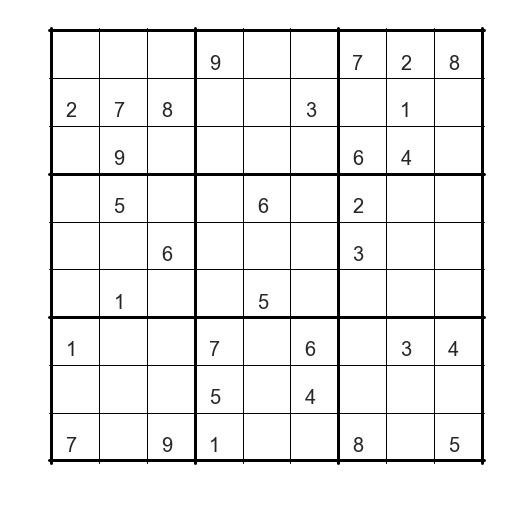

In [19]:
sudoku_hard=np.array([[0,0,0,9,0,0,7,2,8],
                      [2,7,8,0,0,3,0,1,0],
                      [0,9,0,0,0,0,6,4,0],
                      [0,5,0,0,6,0,2,0,0],
                      [0,0,6,0,0,0,3,0,0],
                      [0,1,0,0,5,0,0,0,0],
                      [1,0,0,7,0,6,0,3,4],
                      [0,0,0,5,0,4,0,0,0],
                      [7,0,9,1,0,0,8,0,5]])
plot_sudoku(sudoku_hard)

#sudoku_easy=np.array([[0,0,0,0,0,0,1,0,0],
#                      [0,0,0,7,0,0,0,9,4],
#                      [4,0,0,1,0,0,2,0,0],
#                      [0,2,0,8,0,0,3,5,0],
#                      [5,9,0,0,0,0,0,2,6],
#                      [0,6,8,0,0,5,0,7,0],
#                      [0,0,9,0,0,6,0,0,2],
#                      [8,1,0,0,0,3,0,0,0],
#                      [0,0,5,0,0,0,0,0,0]])
#plot_sudoku(sudoku_easy)

Does brute force work any better here than TSP? 
<b>Answer:</b> let's just do a simple order of magnitude, back of the envelope style calculation.<br>

There are $9 \times 9 =81$ squares in our grid. 26 of these are aleady filled. Leaving 65 empty squares. There are 9 possible numbers that can go into each of the 65 squares, so there are $\sim 10^{60}$ combinations. <br> Let's make a conservative assumption that we can randomly select from our subset, include these into the grid, and then do a test to see if we have solved the puzzle in 1 nano-second (using 1 core), and just because we can, let's say we have a 12-core Mac Pro, so we can do 12 selections at once if we fork our code properly.

So, brute force style it will take $10^{50}$ seconds to go through all the possible combinations. Let's also say, we get lucky and we only go through 1% of the combinations before we find the result. So, exactly how long is $10^{48}$ seconds? Well, the age of the Universe is roughly $4 \times 10^{17}$ seconds...see, a terrible idea!

We've already said that random numbers are the solution here, we just need to be smarter in the way that we do our trials. We know that we achieve this in SA, by comparing the system energy of our previous guess, and comparing this to the energy of our new proposal. So what is the 'energy' in terms of a sudoku puzzle?<br>

Clearly, there is an absolute solution here, so we would expect that $E=0$ for the solution. And $E>0$ for any other incorrect 'solution'. But what makes one solution more wrong than another (i.e., $E>>0$)? <br> 

Let's consider what a correct solution would look like. It would have only unique integers in each row, column and 3x3 box. So, if in a particular row, we had the same number twice, then this must be wrong, and this row would not have $E=0$, but $E=1$, i.e., there is 1 incorrect number. So, the energy of our system is simply the sum of all non-unique numbers in each column, row and 3x3 box. Conversely, we can think of this as the number of unique elements in each row, column, and box, and then we get back to $E=0$ by susbtracting what the enrgy of a correct solution would be, $9 \times 9 \times 3 = 243$, <br>
<center>$ E_{\rm tot} = 243 - \sum_{i,j,k} E_{\rm row,i} + E_{\rm col,j} + E_{box,k}$</center>

In [20]:
def check(i,k,n):
    #determines number of unique elements in each row (k=1) or column (k!=1)
    nums=np.arange(9)+1
    nu=0
    for j in range(9):
        if k==1:
            i1 = n[i][j]-1
        else:
            i1 = n[j][i]-1

        if i1==-1: # Quick check that there are no zeros
            return -1
        
        if nums[i1]!=0:
            nu+=1
            nums[i1]=0
  
    return nu

def checksq(isq, jsq, n):
    # determines number of unique elements in square isq, jsq
    nums=np.arange(9)+1
    nu = 0
    i0 = isq*3
    j0 = jsq*3
    for i in range(3):
        for j in range(3):
            i1 = n[i0+i][j0+j] - 1

            if i1==-1: # Quick check that there are no zeros
                return -1
        
            if nums[i1]!=0:
                nu+=1
                nums[i1]=0
                
    return nu

def calc_energy(n):
    # computes the "energy" of the input grid configuration
    sum = 0
    for i in range(9):
        sum += check(i,1,n) + check(i,2,n)
    
    for i in range(3):
        for j in range(3):
            sum += checksq(i,j,n)

    return 243 - sum

It's important to remember which are the fixed numbers specific to this puzzle, these cannot be moved between interations. We can just use a mask for this.

In [21]:
n = sudoku_hard
mask = n>0

Now, we need a starting position. For this we can take the missing integers from our sudoku example, and apply them pseudo-randomly to the grid. Why pseudo-randomly? We know enough about the final configuration that we can be clever in the way that we distribute the remaining values. We know that the values {1,2,3,4,5,6,7,8,9} must appear in each 3x3 box, so we should only populate those 3x3 squares with those numbers minus those which already exist from this set.

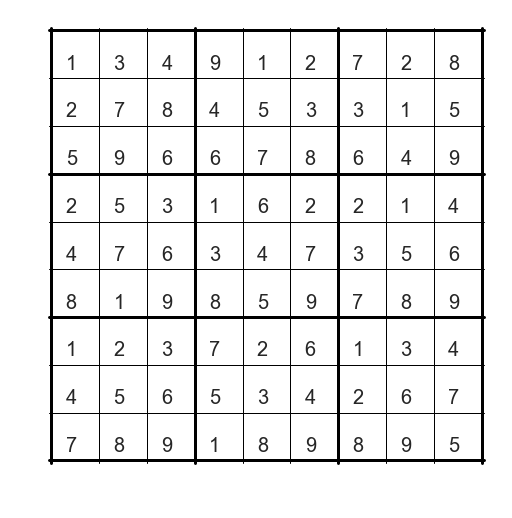

In [22]:
# Assign the remaining integers to open cells so that each block contains all integers once only.
for ib in range(3):
    for jb in range(3):

        nums=np.arange(9)+1  #{1,2...8,9}
        for i in range(3):
            for j in range(3):	 
                i1 = ib*3 + i
                j1 = jb*3 + j

                if n[i1][j1]!=0:
                    ix = n[i1][j1]
                    # replace the already used number with 0
                    nums[ix-1]=0

        # Now we have an array that contains the unused numbers.
        # So we populate using that array.
        iy = -1
        num1=np.zeros(sum(nums>0))
        for k in range(9):
            if nums[k]!=0:
                iy+=1
                num1[iy] = nums[k]

        kk = 0
        for i in range(3):
            for j in range(3):
                i1 = ib*3 + i
                j1 = jb*3 + j
                if(n[i1][j1]==0):
                    n[i1][j1] = num1[kk]
                    kk+=1

plot_sudoku(n)

In [24]:
# What is the energy of our starting position?
e_prev = calc_energy(n)
print('The system Energy of the initial configuration is:', e_prev)

temp = 2.0 # starting temperature
ntrial = 100000 # number of trials we are going to run
thermo= 0.9 # thermostat for the temperature when it's too hot
reanneal=1000 # how often do we apply the thermostat?

The system Energy of the initial configuration is: 48


How should we decide how to construct a proposal? If we are going to smart about this and use SA, then the proposal shouldn't just come out of thin air, it should be based loosely on the accepted grid from the previous iteration. So, we trade numbers. We take a 'movable' number at one grid space and swap it with the number at another grid space. But remember, we distributed the numbers so that in each 3x3 box we had the numbers 1-9. To maintain this, we should make sure that we only swap numbers within the same 3x3 box. We then compute the energy of our proposal grid. If the energy goes down, then we accept. Otherwise toss a coin according to,

<center>${\rm randU}(1) < {\rm exp}\left[-\Delta E / T\right] $</center>

0 1.74290899863 47 47
5000 6.56450052363 27 27
10000 0.00839639091877 16 19
15000 0.00453198485618 4 6
20000 0.000107375181336 2 4
25000 1.8980205928e-07 2 4
30000 0.00716697503761 6 6
35000 0.000233341776988 4 6
40000 7.06583364099e-07 2 4
45000 0.011743628457 16 18
Solution found after 45559 steps


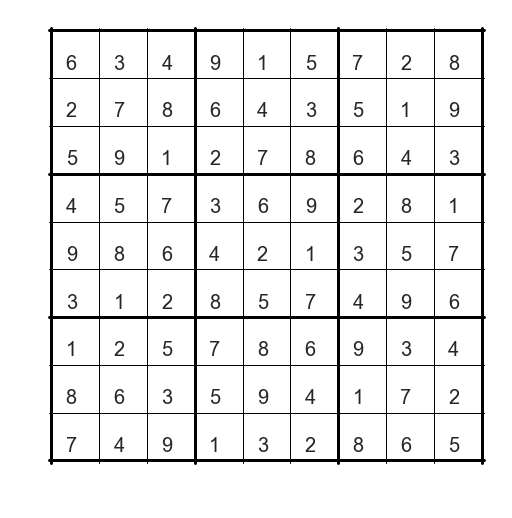

In [27]:
for ll in range(ntrial):

    # at each step pick at random a block and two moveable elements in the block
    ib,jb = 3*np.random.randint(3,size=2)

    i1,j1 = np.random.randint(3,size=2)
    while mask[ib+i1][jb+j1]:
        i1,j1 = np.random.randint(3,size=2)

    i2,j2 = np.random.randint(3,size=2)
    while mask[ib+i2][jb+j2] or (i1==i2 and j1==j2):
        i2,j2 = np.random.randint(3,size=2)

    # swap the movable elements and compute the energy of the trial configuration
    propose_n=n.copy()
    propose_n[ib+i1][jb+j1] = n[ib+i2][jb+j2]
    propose_n[ib+i2][jb+j2] = n[ib+i1][jb+j1]

    # calculate the proposal system energy
    e_new = calc_energy(propose_n)
    deltaE = e_prev - e_new

    # Check the SA criterion
    if e_new < e_prev:
        e_prev = e_new
        n = propose_n
    else:
        if np.random.rand() < np.exp( float(deltaE)/temp):
            e_prev = e_new
            n = propose_n

    # stop computing if the solution is found
    if e_prev==0:
        break

    if(ll % reanneal) == 0:
        temp=temp*thermo
        if temp<0.1:
            temp=0.5
            
    # is the code still running properly...?
    if(ll % 5000) == 0:
        print(ll,np.exp( float(deltaE)/temp),e_prev,e_new)

if e_prev==0:
    print("Solution found after", ll, "steps")
    plot_sudoku(n)

So, how do we improve on this? Can we speed this up? <br>

There are three ways to approach this:<br>
(1) why limit ourselves to only one swap per iteration, at least at the beginning?<br>
(2) intial temperature<br>
(3) thermostat tuning<br>